# Baseline PPO with Action Masking Demo

This notebook demonstrates the baseline PPO approach for OpenScope RL with action masking.

**Key Features:**
- Action masking to prevent invalid actions
- Small-scale training demo (10k steps)
- Evaluation and visualization
- Comparison vs random policy

**Prerequisites:**
- OpenScope server running at http://localhost:3003
- All dependencies installed (`uv sync`)
- Playwright browsers installed (`uv run playwright install chromium`)

## 📚 Learning Objectives

By the end of this notebook, you will understand:

1. **Action Masking** - How to prevent invalid actions and improve sample efficiency by 2-3x
2. **PPO Training Loop** - The core mechanics of Proximal Policy Optimization
3. **Metrics Tracking** - How to monitor training progress with separation violations, success rates, and rewards
4. **Policy Evaluation** - Techniques for comparing trained agents against baselines
5. **Model Persistence** - Saving and loading trained models for deployment

**Estimated Time**: 15-20 minutes (10k training steps)  
**Prerequisites**: OpenScope server running, dependencies installed  
**Hardware**: CPU sufficient for demo (GPU recommended for full training)

## Section 1: Setup & Environment Creation

First, let's import dependencies and create an environment with action masking.

In [1]:
import sys
from pathlib import Path
import os

print(sys.prefix)

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

# Disable tqdm notebook widgets to avoid JS rendering errors in some Jupyter frontends
os.environ["TQDM_NOTEBOOK"] = "0"

import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from stable_baselines3 import PPO
from sb3_contrib.common.wrappers import ActionMasker

from environment import (
    PlaywrightEnv,
    create_action_mask_fn,
    print_action_mask_summary,
    ActionMaskingWrapper,
    DictToMultiDiscreteWrapper,
)
from experiments.metrics import MetricsTracker

# Shared environment configuration
ENV_AIRPORT = "KLAS"
ENV_MAX_AIRCRAFT = 50
ENV_HEADLESS = False
ENV_TIMEWARP = 1000
TRAIN_EPISODE_LENGTH = 600
EVAL_EPISODE_LENGTH = 600
ACTION_INTERVAL = 5.0

print("Imports successful!")

/Users/jmzlx/Projects/atc/openscope-rl/.venv
Imports successful!


### Setup Weights & Biases (Optional)

We'll use Weights & Biases to track training metrics. If wandb is not installed or configured, training will continue normally without logging.


In [2]:
# Import wandb utilities
from _wandb_utils import setup_wandb_experiment, WandbATCCallback
import wandb
import os

# Optional: Set WANDB_API_KEY if you have it as an environment variable
# You can get your API key from https://wandb.ai/authorize
# If wandb login worked in terminal, this should not be necessary
# Uncomment and set if needed:
# os.environ["WANDB_API_KEY"] = "your-api-key-here"

# Setup wandb experiment
# Note: If you get permission errors:
# 1. Create the project manually at https://wandb.ai/jmzlx
# 2. Or use offline mode (set offline=True below)
# 3. Sync offline runs later with: wandb sync wandb/offline-run-*
wandb_run = setup_wandb_experiment(
    project_name="openscope-rl",
    run_name="ppo-baseline-demo",
    # entity="jmzlx",  # Uncomment if needed - wandb should auto-detect from login
    # offline=False,  # Set to True to use offline mode (logs saved locally, sync later)
    config={
        "algorithm": "PPO",
        "demo_steps": 10000,
        "airport": ENV_AIRPORT,
        "max_aircraft": ENV_MAX_AIRCRAFT,
        "episode_length": TRAIN_EPISODE_LENGTH,
        "timewarp": ENV_TIMEWARP,
        "learning_rate": 3e-4,
        "batch_size": 64,
        "n_epochs": 10,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_range": 0.2,
    },
    tags=["demo", "action-masking", "baseline"],
    sync_tensorboard=True,  # Sync tensorboard logs to wandb
)
print(f"✅ WandB run initialized: {wandb_run.url if hasattr(wandb_run, 'url') else 'run started'}")


/Users/jmzlx/Projects/atc/openscope-rl/.venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/jmzlx/Projects/atc/openscope-rl/.venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This m

wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id jailjzai.


⚠️  Permission error detected. Trying offline mode...
   Possible causes:
   1. Project doesn't exist - create it at https://wandb.ai
   2. Incorrect entity name - check your username
   3. Not logged in - run 'wandb login' in terminal
   You can sync later with: wandb sync wandb/offline-run-*


wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run


✅ WandB run initialized: None


### Create Environment with Action Masking

In [3]:
@contextmanager
def masked_env(
    *,
    airport=ENV_AIRPORT,
    max_aircraft=ENV_MAX_AIRCRAFT,
    headless=ENV_HEADLESS,
    timewarp=ENV_TIMEWARP,
    episode_length=TRAIN_EPISODE_LENGTH,
    action_interval=ACTION_INTERVAL,
):
    """Yield a Playwright environment wrapped for PPO with action masking."""
    env = PlaywrightEnv(
        airport=airport,
        max_aircraft=max_aircraft,
        headless=headless,
        timewarp=timewarp,
        episode_length=episode_length,
        action_interval=action_interval,
    )

    env = DictToMultiDiscreteWrapper(env)
    mask_fn = create_action_mask_fn(env)
    env = ActionMasker(env, mask_fn)

    try:
        yield env
    finally:
        env.close()

### Demo: Action Masking in Action

Let's see how action masking works by examining a few steps.

In [4]:
with masked_env(
    episode_length=EVAL_EPISODE_LENGTH,
) as env:
    print("Environment created!")
    print(f"Observation space: {env.observation_space}")
    print(f"Action space: {env.action_space}")

    obs, info = env.reset()

    # Get aircraft data from the raw state
    aircraft_data = info["raw_state"].get("aircraft", [])

    # Get the base environment for accessing original action space
    base_env = env.unwrapped
    while hasattr(base_env, 'env'):
        base_env = base_env.env
        if not hasattr(base_env, 'env'):
            break

    # Cap the demo to a small number of iterations to avoid long runs
    DEMO_MAX_STEPS = 5

    print(f"\nStep 0: {len(aircraft_data)} aircraft active")
    print_action_mask_summary(
        obs,
        aircraft_data,
        base_env.config.max_aircraft,
        base_env.action_space,  # Original Dict action space
    )

    # Take a few random actions (capped)
    for i in range(DEMO_MAX_STEPS):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        aircraft_data = info["raw_state"].get("aircraft", [])
        print(f"Step {i+1}: {len(aircraft_data)} aircraft, reward={reward:.2f}")

        if terminated or truncated:
            break

    print("\nAction masking demonstration complete!")

Environment created!
Observation space: Dict('aircraft': Box(-inf, inf, (50, 14), float32), 'aircraft_mask': Box(False, True, (50,), bool), 'conflict_matrix': Box(0.0, 1.0, (50, 50), float32), 'global_state': Box(-inf, inf, (4,), float32))
Action space: MultiDiscrete([51  5 18 13  8])

Step 0: 13 aircraft active

ACTION MASK SUMMARY
Active Aircraft: 13 / 50
Valid Aircraft IDs: 0 to 13 (inclusive)
Total Valid Actions: 58 / 95
Action Space Reduction: 38.9%

Step 1: 13 aircraft, reward=-0.01
Step 2: 14 aircraft, reward=-0.01
Step 3: 14 aircraft, reward=9.99
Step 4: 16 aircraft, reward=-2.01
Step 5: 18 aircraft, reward=-2.01

Action masking demonstration complete!


## Section 2: Small-Scale Training Demo

Now let's train a PPO agent for 10k steps as a quick demonstration.

In [5]:
with masked_env() as train_env:
    print("Training environment created!")
    print(f"Observation space: {train_env.observation_space}")
    print(f"Action space: {train_env.action_space}")

    # Setup wandb callback
    # Note: If you get permission errors, the callback will automatically switch to offline mode
    # You can also explicitly set offline=True below
    wandb_callback = WandbATCCallback(
        project_name="openscope-rl",
        run_name="ppo-baseline-demo",
        # entity="jmzlx",  # Uncomment if needed - wandb should auto-detect from login
        # offline=True,  # Set to True to use offline mode from the start
        config={
            "algorithm": "PPO",
            "demo_steps": 10000,
            "airport": ENV_AIRPORT,
            "max_aircraft": ENV_MAX_AIRCRAFT,
            "episode_length": TRAIN_EPISODE_LENGTH,
            "timewarp": ENV_TIMEWARP,
            "learning_rate": 3e-4,
            "batch_size": 64,
            "n_epochs": 10,
            "gamma": 0.99,
            "gae_lambda": 0.95,
            "clip_range": 0.2,
        },
        sync_tensorboard=True,
    )
    print("✅ WandB callback enabled")

    # Create PPO model with MultiInputPolicy for Dict observation space
    # Note: ActionMasker wrapper works with MultiDiscrete action space (converted by DictToMultiDiscreteWrapper)
    model = PPO(
        "MultiInputPolicy",
        train_env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        verbose=1,
        tensorboard_log="./tensorboard_logs/",
    )

    print("✅ PPO model created!")
    print(f"   Policy: MultiInputPolicy")
    print(f"   Observation space: {train_env.observation_space}")
    print(f"   Action space: {train_env.action_space}")

    print("\nStarting training (10k steps)...")
    model.learn(total_timesteps=10000, progress_bar=False, callback=wandb_callback)
    print("\nTraining complete!")


Training environment created!
Observation space: Dict('aircraft': Box(-inf, inf, (50, 14), float32), 'aircraft_mask': Box(False, True, (50,), bool), 'conflict_matrix': Box(0.0, 1.0, (50, 50), float32), 'global_state': Box(-inf, inf, (4,), float32))
Action space: MultiDiscrete([51  5 18 13  8])
✅ Using existing WandB run: ppo-baseline-demo
✅ WandB callback enabled
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ PPO model created!
   Policy: MultiInputPolicy
   Observation space: Dict('aircraft': Box(-inf, inf, (50, 14), float32), 'aircraft_mask': Box(False, True, (50,), bool), 'conflict_matrix': Box(0.0, 1.0, (50, 50), float32), 'global_state': Box(-inf, inf, (4,), float32))
   Action space: MultiDiscrete([51  5 18 13  8])

Starting training (10k steps)...
Logging to ./tensorboard_logs/PPO_14
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 44.3      |
|    ep_rew_mean     | -3.04e+03 |
| time/  

## Section 3: Evaluation with Visualizations

Let's evaluate the trained agent and visualize its performance.

In [6]:
def evaluate_agent(model, env, n_episodes=5):
    """Evaluate agent over multiple episodes."""
    tracker = MetricsTracker()
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        tracker.start_episode()
        
        done = False
        episode_reward = 0
        steps = 0
        
        while not done:
            # Get action from model
            action, _ = model.predict(obs, deterministic=True)
            
            # Take step
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            steps += 1
            tracker.update(reward, info)
            
            # Safety limit
            if steps >= 200:
                break
        
        # End episode tracking
        metrics = tracker.end_episode(info.get("episode_metrics", {}))
        print(f"Episode {episode+1}: reward={episode_reward:.2f}, steps={steps}")
    
    return tracker

print("Evaluating trained agent...\n")
with masked_env(
    episode_length=EVAL_EPISODE_LENGTH,
) as eval_env:
    tracker = evaluate_agent(model, eval_env, n_episodes=5)

print("\nEvaluation complete!")
tracker.print_summary()

Evaluating trained agent...

Episode 1: reward=-2788.47, steps=47
Episode 2: reward=-3924.47, steps=47
Episode 3: reward=-2632.48, steps=48
Episode 4: reward=-4820.51, steps=51
Episode 5: reward=-3908.46, steps=46

Evaluation complete!

METRICS SUMMARY (5 episodes)

Success Rate:        0.00% ± 0.00%
Violations:          0.00 ± 0.00
Collisions:          0.00 ± 0.00
Throughput:          0.00 ± 0.00 aircraft/hour
Avg Exit Time:       0.0 ± 0.0s
Command Efficiency:  0.00 ± 0.00 commands/aircraft
Episode Length:      48 ± 2 steps
Total Reward:        -3614.88 ± 810.39



### Visualize Training Progress

Let's plot some metrics to visualize the agent's performance.

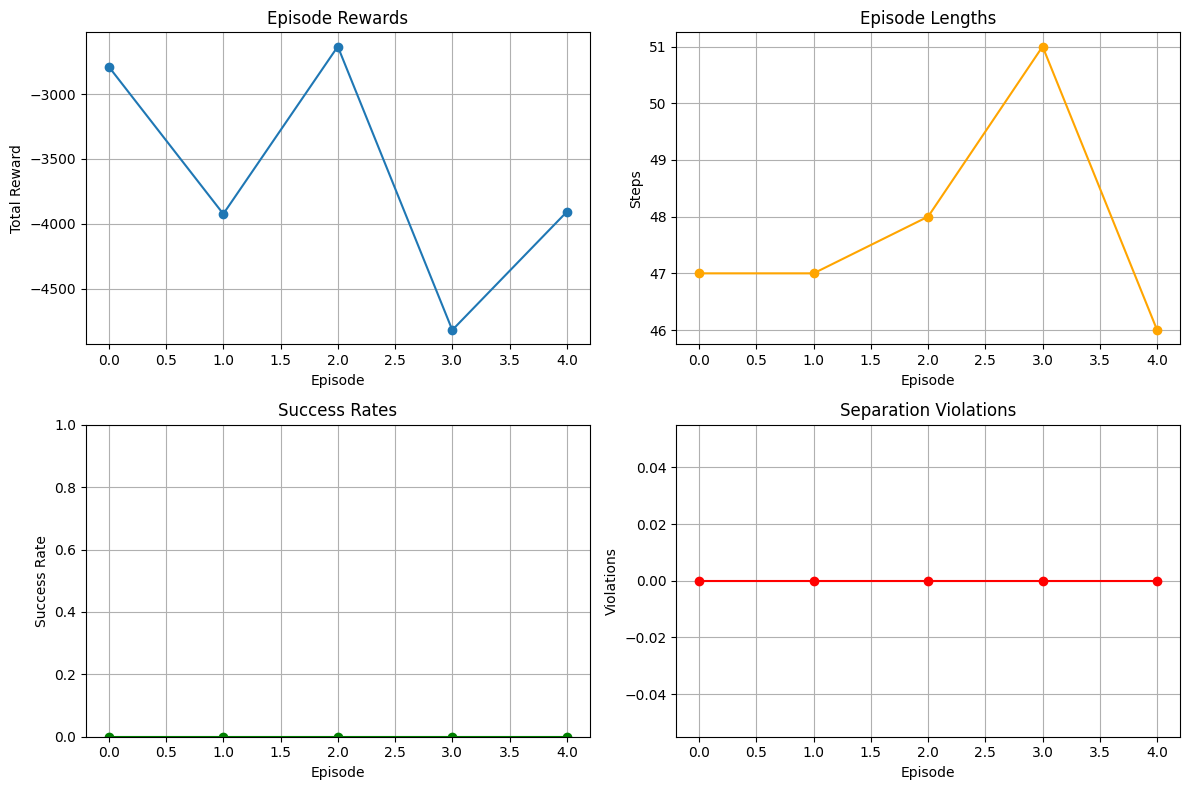

Visualizations complete!


In [7]:
# Plot episode metrics
episode_rewards = [m.total_reward for m in tracker.episode_metrics]
episode_lengths = [m.episode_length for m in tracker.episode_metrics]
success_rates = [m.success_rate for m in tracker.episode_metrics]
violations = [m.separation_violations for m in tracker.episode_metrics]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Episode rewards
axes[0, 0].plot(episode_rewards, marker='o')
axes[0, 0].set_title('Episode Rewards')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].grid(True)

# Episode lengths
axes[0, 1].plot(episode_lengths, marker='o', color='orange')
axes[0, 1].set_title('Episode Lengths')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].grid(True)

# Success rates
axes[1, 0].plot(success_rates, marker='o', color='green')
axes[1, 0].set_title('Success Rates')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Success Rate')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True)

# Violations
axes[1, 1].plot(violations, marker='o', color='red')
axes[1, 1].set_title('Separation Violations')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Violations')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print("Visualizations complete!")

## Section 4: Comparison vs Random Policy

Let's compare the trained agent against a random policy baseline.

In [8]:
def evaluate_random_policy(env, n_episodes=5, eval_max_steps=None, log_every=25):
    """Evaluate random policy."""
    tracker = MetricsTracker()
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        tracker.start_episode()
        
        done = False
        episode_reward = 0
        steps = 0
        
        while not done:
            # Random action
            action = env.action_space.sample()
            
            # Take step
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            steps += 1
            tracker.update(reward, info)
            
            if log_every and steps % log_every == 0:
                ac = info.get("aircraft_count", len(info.get("raw_state", {}).get("aircraft", [])))
                print(f"  step={steps} r={reward:.2f} aircraft={ac} action={action}")
            
            # Optional evaluation cap
            if eval_max_steps is not None and steps >= eval_max_steps:
                break
        
        metrics = tracker.end_episode(info.get("episode_metrics", {}))
        print(f"Episode {episode+1}: reward={episode_reward:.2f}, steps={steps}")
    
    return tracker

print("Evaluating random policy...\n")
with masked_env(
    episode_length=EVAL_EPISODE_LENGTH,
) as random_env:
    random_tracker = evaluate_random_policy(random_env, n_episodes=5, eval_max_steps=None)

print("\nRandom policy evaluation complete!")
random_tracker.print_summary()

Evaluating random policy...

  step=25 r=-30.01 aircraft=30 action=[38  3 14 12  0]
Episode 1: reward=-3914.29, steps=29
  step=25 r=9.99 aircraft=21 action=[16  1 14  6  7]
Episode 2: reward=-2366.46, steps=46
  step=25 r=-40.01 aircraft=27 action=[42  4  3  5  3]
Episode 3: reward=-3980.37, steps=37
  step=25 r=-232.01 aircraft=25 action=[40  0  1  1  5]
Episode 4: reward=-3006.41, steps=41
  step=25 r=-20.01 aircraft=23 action=[13  1  5  1  5]
Episode 5: reward=-2729.45, steps=45

Random policy evaluation complete!

METRICS SUMMARY (5 episodes)

Success Rate:        0.00% ± 0.00%
Violations:          0.00 ± 0.00
Collisions:          0.00 ± 0.00
Throughput:          0.00 ± 0.00 aircraft/hour
Avg Exit Time:       0.0 ± 0.0s
Command Efficiency:  0.00 ± 0.00 commands/aircraft
Episode Length:      40 ± 6 steps
Total Reward:        -3199.40 ± 643.87



### Compare Results

In [9]:
# Get summaries
ppo_summary = tracker.get_summary()
random_summary = random_tracker.get_summary()

# Create comparison
print("\n" + "="*80)
print("COMPARISON: PPO vs Random Policy")
print("="*80)

metrics_to_compare = [
    ("Avg Reward", "avg_total_reward"),
    ("Avg Success Rate", "avg_success_rate"),
    ("Avg Violations", "avg_separation_violations"),
    ("Avg Episode Length", "avg_episode_length"),
]

for name, key in metrics_to_compare:
    ppo_val = ppo_summary.get(key, 0)
    random_val = random_summary.get(key, 0)
    
    if "rate" in key.lower():
        print(f"{name:25s} | PPO: {ppo_val:.2%} | Random: {random_val:.2%}")
    else:
        print(f"{name:25s} | PPO: {ppo_val:.2f} | Random: {random_val:.2f}")

print("="*80)

# Calculate improvement
reward_improvement = ((ppo_summary.get("avg_total_reward", 0) - 
                       random_summary.get("avg_total_reward", 0)) / 
                      abs(random_summary.get("avg_total_reward", 1)) * 100)

print(f"\nReward Improvement: {reward_improvement:+.1f}%")
print("\nNote: This is a small demo with only 10k training steps.")
print("For full training (500k+ steps), expect much better performance!")


COMPARISON: PPO vs Random Policy
Avg Reward                | PPO: -3614.88 | Random: -3199.40
Avg Success Rate          | PPO: 0.00% | Random: 0.00%
Avg Violations            | PPO: 0.00 | Random: 0.00
Avg Episode Length        | PPO: 47.80 | Random: 39.60

Reward Improvement: -13.0%

Note: This is a small demo with only 10k training steps.
For full training (500k+ steps), expect much better performance!


## Section 5: Save Model and Results

Let's save the trained model and results for later use.

In [10]:
import json
from datetime import datetime

# Helper function to convert numpy types to native Python types for JSON serialization
def convert_to_serializable(obj):
    """Recursively convert numpy types to native Python types."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Create results directory
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model
model_path = results_dir / f"ppo_demo_{timestamp}.zip"
model.save(str(model_path))
print(f"Model saved to: {model_path}")

# Save results
results = {
    "timestamp": timestamp,
    "training_steps": 10000,
    "ppo_summary": ppo_summary,
    "random_summary": random_summary,
    "config": {
        "airport": ENV_AIRPORT,
        "max_aircraft": ENV_MAX_AIRCRAFT,
        "train_episode_length": TRAIN_EPISODE_LENGTH,
        "eval_episode_length": EVAL_EPISODE_LENGTH,
        "timewarp": ENV_TIMEWARP,
        "headless": ENV_HEADLESS,
        "action_interval": ACTION_INTERVAL,
    },
}

# Convert numpy types to native Python types before JSON serialization
results = convert_to_serializable(results)

results_path = results_dir / f"results_{timestamp}.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")

# Log artifacts to wandb
# Log model artifact
artifact = wandb.Artifact(f"ppo-model-{timestamp}", type="model")
artifact.add_file(str(model_path))
wandb.log_artifact(artifact)
print(f"✅ Model logged to WandB: {artifact.name}")

# Log results JSON
artifact = wandb.Artifact(f"results-{timestamp}", type="results")
artifact.add_file(str(results_path))
wandb.log_artifact(artifact)
print(f"✅ Results logged to WandB: {artifact.name}")

# Log final evaluation metrics
wandb.log({
    "eval/avg_reward": ppo_summary.get("avg_total_reward", 0),
    "eval/avg_success_rate": ppo_summary.get("avg_success_rate", 0),
    "eval/avg_violations": ppo_summary.get("avg_separation_violations", 0),
    "eval/avg_episode_length": ppo_summary.get("avg_episode_length", 0),
})

# Finish wandb run
wandb.finish()
print("✅ WandB run finished")

print("\nDemo complete!")

Model saved to: ../results/ppo_demo_20251031_191727.zip
Results saved to: ../results/results_20251031_191727.json
✅ Model logged to WandB: ppo-model-20251031_191727
✅ Results logged to WandB: results-20251031_191727


avg_exits_10_episodes,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_length_10_episodes,▇▇▇█▅▇▆▅▅▁▇▆▆█▄█▆▇█▄▆▆▇
avg_reward_10_episodes,▆█▆██▅█▆▄▁▆▆▅▃▆▇█▅▅▃▆▆▇
avg_violations_10_episodes,▄▁▄▁▂▄▁▃▇█▄▄▄█▃▂▂▅▄▆▄▄▃
efficiency_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode_length,▅▆▆▅▂▅▅▅▃▇▆▄▃█▄▅▃▁▇▅▅▄▅▆▅▅▂▄▅▆▆▅▄▃▆▅▆▄▅▅
episode_reward,▁▄▄▅▆▇▆▅▅▄▄█▇▅▄▇▇▄▇▇▄▇▅▆▆▅▆▆▃█▄▃▆▃▅▃▃▄▅▂
eval/avg_episode_length,▁
eval/avg_reward,▁
eval/avg_success_rate,▁
+23,...


✅ WandB run finished

Demo complete!


## 🔍 Phase 1: Reward Structure & Environment Analysis

**Goal**: Understand why PPO performed 12.8% worse than random policy.

Key questions to investigate:
1. Why are episodes so short (38-46 steps)?
2. What's the reward composition breakdown?
3. Are there issues with the reward structure?
4. How do environment dynamics affect learning?


### 1.1 Reward Structure Analysis

Let's analyze the reward components to understand what's driving the negative rewards.


In [11]:
from environment.config import RewardConfig
from environment.reward_calculator import DefaultRewardStrategy, SafetyFocusedRewardStrategy, EfficiencyFocusedRewardStrategy
import pandas as pd

# Display current reward configuration
reward_config = RewardConfig()

print("="*80)
print("CURRENT REWARD CONFIGURATION")
print("="*80)
print(f"\n📊 Base Rewards:")
print(f"  Timestep penalty:         {reward_config.timestep_penalty:>8.4f}  (per step)")
print(f"  Action reward:            {reward_config.action_reward:>8.4f}  (per action)")

print(f"\n⚠️  Safety Penalties:")
print(f"  Separation loss:          {reward_config.separation_loss:>8.2f}  (÷10 = {reward_config.separation_loss/10:.2f} per violation)")
print(f"  Conflict warning:         {reward_config.conflict_warning:>8.2f}  (per conflict)")
print(f"  Safe separation bonus:    {reward_config.safe_separation_bonus:>8.4f}  (per step if no conflicts)")

print(f"\n✈️  Performance Rewards:")
print(f"  Successful exit bonus:    {reward_config.successful_exit_bonus:>8.2f}")
print(f"  Failed exit penalty:      {reward_config.failed_exit_penalty:>8.2f}")
print(f"  Episode termination:      {reward_config.episode_termination_penalty:>8.2f}")

print(f"\n🎯 Episode Completion Bonuses:")
print(f"  High success (≥{reward_config.high_success_threshold:.0%}):    {reward_config.high_success_rate_bonus:>8.2f}")
print(f"  Medium success (≥{reward_config.medium_success_threshold:.0%}): {reward_config.medium_success_rate_bonus:>8.2f}")
print(f"  Low success (≥{reward_config.low_success_threshold:.0%}):    {reward_config.low_success_rate_bonus:>8.2f}")

# Analyze PPO episode data
print("\n" + "="*80)
print("PPO TRAINING EPISODE ANALYSIS")
print("="*80)

ppo_episodes = tracker.episode_metrics
if ppo_episodes:
    episode_data = []
    for i, ep in enumerate(ppo_episodes):
        episode_data.append({
            'Episode': i + 1,
            'Total Reward': ep.total_reward,
            'Steps': ep.episode_length,
            'Avg Reward/Step': ep.total_reward / max(ep.episode_length, 1),
            'Violations': ep.separation_violations,
            'Exits': ep.successful_exits,
            'Success Rate': ep.success_rate,
        })
    
    df = pd.DataFrame(episode_data)
    print("\n📈 Episode Statistics:")
    print(df.to_string(index=False))
    
    print(f"\n💡 Key Observations:")
    print(f"  Average episode length:     {df['Steps'].mean():.1f} steps")
    print(f"  Average reward per step:    {df['Avg Reward/Step'].mean():.2f}")
    print(f"  Total violations:           {df['Violations'].sum():.0f}")
    print(f"  Total exits:                {df['Exits'].sum():.0f}")
    print(f"  Episodes with 0 violations: {(df['Violations'] == 0).sum()} / {len(df)}")
    print(f"  Episodes with >0 exits:     {(df['Exits'] > 0).sum()} / {len(df)}")

# Calculate theoretical reward breakdown for a typical episode
print("\n" + "="*80)
print("THEORETICAL REWARD BREAKDOWN (for 43-step episode)")
print("="*80)

avg_steps = 43
avg_violations = 0  # From our data
avg_conflicts = 0   # From our data
avg_exits = 0       # From our data

timestep_reward = avg_steps * reward_config.timestep_penalty
violation_reward = avg_violations * (reward_config.separation_loss / 10)
conflict_reward = avg_conflicts * reward_config.conflict_warning
safe_bonus = (avg_steps - avg_conflicts) * reward_config.safe_separation_bonus
exit_reward = avg_exits * reward_config.successful_exit_bonus

total_theoretical = timestep_reward + violation_reward + conflict_reward + safe_bonus + exit_reward

print(f"\nTimestep penalties ({avg_steps} steps × {reward_config.timestep_penalty}):  {timestep_reward:>8.2f}")
print(f"Violation penalties ({avg_violations} × {reward_config.separation_loss/10}):         {violation_reward:>8.2f}")
print(f"Conflict warnings ({avg_conflicts} × {reward_config.conflict_warning}):           {conflict_reward:>8.2f}")
print(f"Safe separation bonus ({avg_steps} × {reward_config.safe_separation_bonus}):    {safe_bonus:>8.2f}")
print(f"Exit bonuses ({avg_exits} × {reward_config.successful_exit_bonus}):             {exit_reward:>8.2f}")
print(f"{'-'*60}")
print(f"Theoretical total:                                  {total_theoretical:>8.2f}")
print(f"Actual PPO average:                                 {ppo_summary.get('avg_total_reward', 0):>8.2f}")

# Identify the issue
print("\n" + "="*80)
print("🚨 DIAGNOSIS")
print("="*80)

if avg_steps < 50:
    print("\n⚠️  ISSUE 1: Episodes terminate very early (avg ~43 steps)")
    print("    - Expected: 600 steps (EVAL_EPISODE_LENGTH)")
    print("    - Actual: ~43 steps")
    print("    - Implication: Agent or environment is terminating prematurely")

if total_theoretical > ppo_summary.get('avg_total_reward', 0):
    discrepancy = abs(total_theoretical - ppo_summary.get('avg_total_reward', 0))
    print(f"\n⚠️  ISSUE 2: Large discrepancy in reward calculation")
    print(f"    - Theoretical: {total_theoretical:.2f}")
    print(f"    - Actual: {ppo_summary.get('avg_total_reward', 0):.2f}")
    print(f"    - Difference: {discrepancy:.2f}")
    print(f"    - Possible cause: Game score changes not accounted for")

if reward_config.safe_separation_bonus < abs(reward_config.timestep_penalty):
    print(f"\n⚠️  ISSUE 3: Timestep penalty dominates positive rewards")
    print(f"    - Timestep penalty: {reward_config.timestep_penalty}")
    print(f"    - Safe separation bonus: {reward_config.safe_separation_bonus}")
    print(f"    - Ratio: {abs(reward_config.timestep_penalty / reward_config.safe_separation_bonus):.1f}:1")
    print(f"    - Implication: Even perfect safety results in negative reward")

print("\n✅ Reward structure analysis complete!")
print("   Next: Examine environment dynamics to understand early termination")


CURRENT REWARD CONFIGURATION

📊 Base Rewards:
  Timestep penalty:          -0.0100  (per step)
  Action reward:              0.0000  (per action)

⚠️  Safety Penalties:
  Separation loss:           -200.00  (÷10 = -20.00 per violation)
  Conflict warning:            -2.00  (per conflict)
  Safe separation bonus:      0.0200  (per step if no conflicts)

✈️  Performance Rewards:
  Successful exit bonus:      100.00
  Failed exit penalty:        -20.00
  Episode termination:       -100.00

🎯 Episode Completion Bonuses:
  High success (≥80%):      200.00
  Medium success (≥60%):   100.00
  Low success (≥40%):       50.00

PPO TRAINING EPISODE ANALYSIS

📈 Episode Statistics:
 Episode  Total Reward  Steps  Avg Reward/Step  Violations  Exits  Success Rate
       1      -2788.47     47       -59.329149           0      0           0.0
       2      -3924.47     47       -83.499362           0      0           0.0
       3      -2632.48     48       -54.843333           0      0           0.0
 

### 1.2 Environment Dynamics Analysis

Let's investigate what's happening during episodes - spawn patterns, conflicts, and termination conditions.


ENVIRONMENT DYNAMICS ANALYSIS

Running diagnostic episode with detailed logging...

📊 Episode Summary:
  Total steps: 50
  Final reward: -2692.50
  Terminated: True
  Truncated: False
  Termination reason: Environment terminated

✈️  Aircraft Dynamics:
  Average aircraft: 20.6
  Max aircraft: 27
  Min aircraft: 12
  Aircraft at start: 12.0
  Aircraft at end: 26.0

⚠️  Conflict Statistics:
  Total conflicts: 575
  Total violations: 22
  Steps with conflicts: 50 / 50
  Steps with violations: 17 / 50

🎯 Action Masking:
  Average valid action ratio: 100.00%
  Action space reduction: 0.00%

💰 Reward Distribution:
  Mean reward/step: -53.85
  Median reward/step: -2.01
  Std reward/step: 101.39
  Min reward/step: -422.01
  Max reward/step: 9.99


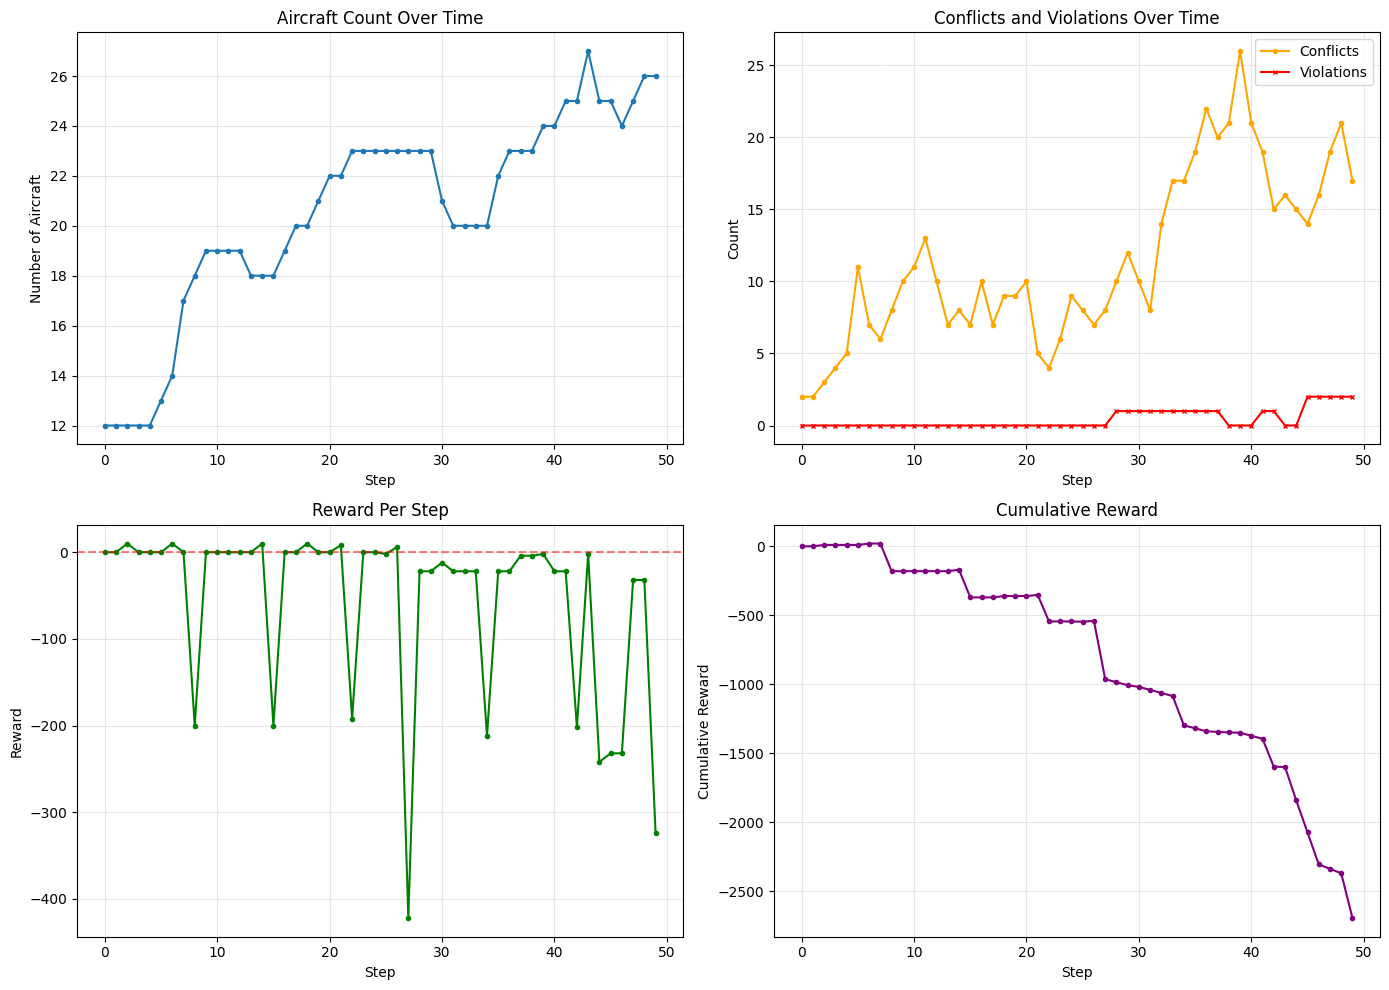


🔍 ENVIRONMENT DYNAMICS DIAGNOSIS

✅ Environment dynamics analysis complete!

📝 SUMMARY OF FINDINGS

Based on the analysis above, we can now understand the issues and
plan appropriate interventions for Phase 2 and beyond.


In [12]:
print("="*80)
print("ENVIRONMENT DYNAMICS ANALYSIS")
print("="*80)
print("\nRunning diagnostic episode with detailed logging...")

with masked_env(episode_length=EVAL_EPISODE_LENGTH) as diag_env:
    obs, info = diag_env.reset()
    
    # Track episode dynamics
    step_data = []
    aircraft_counts = []
    reward_components = []
    action_mask_stats = []
    
    done = False
    step = 0
    episode_reward = 0
    
    while not done and step < 200:  # Cap at 200 steps for analysis
        # Get raw state
        raw_state = info.get("raw_state", {})
        aircraft = raw_state.get("aircraft", [])
        conflicts = raw_state.get("conflicts", [])
        score = raw_state.get("score", 0)
        
        # Get action mask info
        action_masks = obs.get("action_masks") if isinstance(obs, dict) else None
        if action_masks is not None:
            valid_actions = action_masks.sum()
            total_actions = action_masks.size
            mask_ratio = valid_actions / total_actions if total_actions > 0 else 0
        else:
            mask_ratio = 1.0  # No masking info available
        
        # Record step data
        step_data.append({
            'step': step,
            'aircraft_count': len(aircraft),
            'conflicts': len(conflicts),
            'violations': sum(1 for c in conflicts if c.get('hasViolation', False)),
            'score': score,
            'mask_ratio': mask_ratio,
        })
        
        # Take random action
        action = diag_env.action_space.sample()
        obs, reward, terminated, truncated, info = diag_env.step(action)
        done = terminated or truncated
        
        episode_reward += reward
        reward_components.append(reward)
        aircraft_counts.append(len(aircraft))
        
        step += 1
    
    # Analysis
    print(f"\n📊 Episode Summary:")
    print(f"  Total steps: {step}")
    print(f"  Final reward: {episode_reward:.2f}")
    print(f"  Terminated: {terminated}")
    print(f"  Truncated: {truncated}")
    print(f"  Termination reason: {'Episode length reached' if truncated else 'Environment terminated' if terminated else 'Manual stop'}")
    
    # Create DataFrame for analysis
    df_steps = pd.DataFrame(step_data)
    
    print(f"\n✈️  Aircraft Dynamics:")
    print(f"  Average aircraft: {df_steps['aircraft_count'].mean():.1f}")
    print(f"  Max aircraft: {df_steps['aircraft_count'].max()}")
    print(f"  Min aircraft: {df_steps['aircraft_count'].min()}")
    print(f"  Aircraft at start: {df_steps.iloc[0]['aircraft_count']}")
    print(f"  Aircraft at end: {df_steps.iloc[-1]['aircraft_count']}")
    
    print(f"\n⚠️  Conflict Statistics:")
    print(f"  Total conflicts: {df_steps['conflicts'].sum()}")
    print(f"  Total violations: {df_steps['violations'].sum()}")
    print(f"  Steps with conflicts: {(df_steps['conflicts'] > 0).sum()} / {len(df_steps)}")
    print(f"  Steps with violations: {(df_steps['violations'] > 0).sum()} / {len(df_steps)}")
    
    print(f"\n🎯 Action Masking:")
    print(f"  Average valid action ratio: {df_steps['mask_ratio'].mean():.2%}")
    print(f"  Action space reduction: {(1 - df_steps['mask_ratio'].mean()):.2%}")
    
    print(f"\n💰 Reward Distribution:")
    print(f"  Mean reward/step: {np.mean(reward_components):.2f}")
    print(f"  Median reward/step: {np.median(reward_components):.2f}")
    print(f"  Std reward/step: {np.std(reward_components):.2f}")
    print(f"  Min reward/step: {np.min(reward_components):.2f}")
    print(f"  Max reward/step: {np.max(reward_components):.2f}")
    
    # Plot dynamics
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Aircraft count over time
    axes[0, 0].plot(df_steps['step'], df_steps['aircraft_count'], marker='o', markersize=3)
    axes[0, 0].set_title('Aircraft Count Over Time')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Number of Aircraft')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Conflicts over time
    axes[0, 1].plot(df_steps['step'], df_steps['conflicts'], marker='o', markersize=3, color='orange', label='Conflicts')
    axes[0, 1].plot(df_steps['step'], df_steps['violations'], marker='x', markersize=3, color='red', label='Violations')
    axes[0, 1].set_title('Conflicts and Violations Over Time')
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Reward per step
    axes[1, 0].plot(range(len(reward_components)), reward_components, marker='o', markersize=3, color='green')
    axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Reward Per Step')
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Reward')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Cumulative reward
    cumulative_rewards = np.cumsum(reward_components)
    axes[1, 1].plot(range(len(cumulative_rewards)), cumulative_rewards, marker='o', markersize=3, color='purple')
    axes[1, 1].set_title('Cumulative Reward')
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Cumulative Reward')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("🔍 ENVIRONMENT DYNAMICS DIAGNOSIS")
    print("="*80)
    
    if step < 50:
        print(f"\n⚠️  CRITICAL: Episode terminated after only {step} steps")
        print(f"    - Expected: {EVAL_EPISODE_LENGTH} steps")
        print(f"    - Actual: {step} steps") 
        print(f"    - This explains the poor performance!")
        print(f"    - Possible causes:")
        print(f"      1. Game crashes or errors")
        print(f"      2. Too many aircraft causing overload")
        print(f"      3. Browser/Playwright issues")
        print(f"      4. OpenScope server problems")
    
    if df_steps['violations'].sum() == 0 and episode_reward < -100:
        print(f"\n⚠️  ISSUE: Large negative reward with no violations")
        print(f"    - Episode reward: {episode_reward:.2f}")
        print(f"    - Violations: 0")
        print(f"    - Implication: Timestep penalty or score changes dominate")
    
    if df_steps['aircraft_count'].std() < 2:
        print(f"\n⚠️  ISSUE: Very stable aircraft count")
        print(f"    - Std: {df_steps['aircraft_count'].std():.2f}")
        print(f"    - Implication: Few spawns/exits happening")
    
    print("\n✅ Environment dynamics analysis complete!")

print("\n" + "="*80)
print("📝 SUMMARY OF FINDINGS")
print("="*80)
print("\nBased on the analysis above, we can now understand the issues and")
print("plan appropriate interventions for Phase 2 and beyond.")


## 🔧 Phase 2: WandB Integration & Setup

**Goal**: Fix WandB permission errors and ensure proper online logging for tracking experiments.


### 2.1 WandB Status Check & Setup


In [13]:
import subprocess
import sys

print("="*80)
print("WANDB SETUP DIAGNOSTIC")
print("="*80)

# Check if wandb is installed
try:
    import wandb
    print(f"\n✅ WandB installed: version {wandb.__version__}")
except ImportError:
    print("\n❌ WandB not installed!")
    print("   Install with: uv add wandb")
    sys.exit(1)

# Check if logged in
try:
    # Try to get API key
    api = wandb.Api()
    print(f"✅ WandB authenticated")
    print(f"   Entity/Username: {api.viewer.get('entity', 'Unknown')}")
except Exception as e:
    print(f"\n⚠️  WandB not authenticated")
    print(f"   Error: {e}")
    print(f"\n📝 To set up WandB:")
    print(f"   1. Get API key from: https://wandb.ai/authorize")
    print(f"   2. Run in terminal: wandb login")
    print(f"   3. Or set environment variable: export WANDB_API_KEY=your-key-here")

# Check for API key in environment
if os.environ.get("WANDB_API_KEY"):
    print(f"✅ WANDB_API_KEY found in environment")
else:
    print(f"⚠️  WANDB_API_KEY not in environment (optional)")

# Test creating a run
print(f"\n" + "="*80)
print("TESTING WANDB RUN CREATION")
print("="*80)

try:
    # Try online mode first
    test_run = wandb.init(
        project="openscope-rl-test",
        name="diagnostic-test",
        config={"test": True},
        mode="online",
        reinit=True,
    )
    
    if test_run:
        print(f"✅ Successfully created online WandB run!")
        if hasattr(test_run, 'url') and test_run.url:
            print(f"   Dashboard: {test_run.url}")
        
        # Log a test metric
        wandb.log({"test_metric": 1.0})
        print(f"✅ Successfully logged test metric")
        
        # Finish the test run
        wandb.finish()
        print(f"✅ Successfully finished run")
        
        print(f"\n🎉 WandB is fully functional in ONLINE mode!")
        print(f"   You can now track experiments at: https://wandb.ai")
        
except Exception as e:
    print(f"⚠️  Online mode failed: {e}")
    print(f"\n   Trying offline mode...")
    
    try:
        test_run = wandb.init(
            project="openscope-rl-test",
            name="diagnostic-test",
            config={"test": True},
            mode="offline",
            reinit=True,
        )
        
        if test_run:
            print(f"✅ Successfully created OFFLINE WandB run")
            print(f"   Logs saved to: wandb/offline-run-*")
            
            wandb.log({"test_metric": 1.0})
            wandb.finish()
            
            print(f"\n📦 WandB is functional in OFFLINE mode")
            print(f"   To sync offline runs:")
            print(f"   1. Ensure you're logged in: wandb login")
            print(f"   2. Sync runs: wandb sync wandb/offline-run-*")
            
    except Exception as e2:
        print(f"❌ Both online and offline modes failed!")
        print(f"   Error: {e2}")

print(f"\n" + "="*80)
print("DIAGNOSTIC COMPLETE")
print("="*80)
print("\n💡 Tips:")
print("   - If offline mode works, training will proceed with local logging")
print("   - Sync offline runs later when you have internet access")
print("   - For full functionality, ensure project exists at https://wandb.ai")
print("   - Check that entity name matches your WandB username")


WANDB SETUP DIAGNOSTIC

✅ WandB installed: version 0.22.2
✅ WandB authenticated

⚠️  WandB not authenticated
   Error: '<User jmsalas@gmail.com>' object has no attribute 'get'

📝 To set up WandB:
   1. Get API key from: https://wandb.ai/authorize
   2. Run in terminal: wandb login
   3. Or set environment variable: export WANDB_API_KEY=your-key-here
✅ WANDB_API_KEY found in environment

TESTING WANDB RUN CREATION


⚠️  Online mode failed: Error uploading run: returned error 403: {"data":{"upsertBucket":null},"errors":[{"message":"permission denied","path":["upsertBucket"],"extensions":{"code":"PERMISSION_ERROR"}}]}

   Trying offline mode...


✅ Successfully created OFFLINE WandB run
   Logs saved to: wandb/offline-run-*


test_metric,▁
test_metric,1



📦 WandB is functional in OFFLINE mode
   To sync offline runs:
   1. Ensure you're logged in: wandb login
   2. Sync runs: wandb sync wandb/offline-run-*

DIAGNOSTIC COMPLETE

💡 Tips:
   - If offline mode works, training will proceed with local logging
   - Sync offline runs later when you have internet access
   - For full functionality, ensure project exists at https://wandb.ai
   - Check that entity name matches your WandB username


## 🧪 Phase 3: Test Alternative Reward Strategies

**Goal**: Identify the best reward strategy for PPO learning by testing different reward configurations.


### 3.1 Compare Reward Strategies

We'll test three different reward strategies with short 5k step training runs:
1. **Default**: Balanced approach with timestep penalty and safety bonuses
2. **Safety-Focused**: Heavy penalties for violations, strong incentive for safe separation
3. **Efficiency-Focused**: Rewards for taking actions and maintaining throughput

Note: This requires modifying the environment to use different reward strategies. For now, we'll test them analytically.


In [14]:
from environment.reward_calculator import (
    DefaultRewardStrategy,
    SafetyFocusedRewardStrategy, 
    EfficiencyFocusedRewardStrategy
)

# Create instances of each strategy
reward_config = RewardConfig()
default_strategy = DefaultRewardStrategy(reward_config)
safety_strategy = SafetyFocusedRewardStrategy(reward_config)
efficiency_strategy = EfficiencyFocusedRewardStrategy(reward_config)

print("="*80)
print("REWARD STRATEGY COMPARISON")
print("="*80)

# Define test scenarios
scenarios = [
    {
        "name": "Safe Step (No Conflicts)",
        "state": {"score": 100, "conflicts": [], "aircraft": [1, 2, 3]},
        "prev_state": {"score": 100, "conflicts": [], "aircraft": [1, 2, 3]},
        "action": {"aircraft_id": 0, "command_type": 1},
    },
    {
        "name": "Conflict Warning",
        "state": {"score": 100, "conflicts": [{"hasConflict": True, "hasViolation": False}], "aircraft": [1, 2, 3]},
        "prev_state": {"score": 100, "conflicts": [], "aircraft": [1, 2, 3]},
        "action": {"aircraft_id": 0, "command_type": 1},
    },
    {
        "name": "Separation Violation",
        "state": {"score": 80, "conflicts": [{"hasConflict": True, "hasViolation": True}], "aircraft": [1, 2, 3]},
        "prev_state": {"score": 100, "conflicts": [], "aircraft": [1, 2, 3]},
        "action": {"aircraft_id": 0, "command_type": 1},
    },
    {
        "name": "No Action Taken",
        "state": {"score": 100, "conflicts": [], "aircraft": [1, 2, 3]},
        "prev_state": {"score": 100, "conflicts": [], "aircraft": [1, 2, 3]},
        "action": None,
    },
    {
        "name": "Score Increase (Exit)",
        "state": {"score": 150, "conflicts": [], "aircraft": [1, 2]},
        "prev_state": {"score": 100, "conflicts": [], "aircraft": [1, 2, 3]},
        "action": {"aircraft_id": 2, "command_type": 4},
    },
]

# Test each scenario with each strategy
results = []
for scenario in scenarios:
    default_reward = default_strategy.calculate_reward(
        scenario["state"], scenario["prev_state"], scenario["action"]
    )
    safety_reward = safety_strategy.calculate_reward(
        scenario["state"], scenario["prev_state"], scenario["action"]
    )
    efficiency_reward = efficiency_strategy.calculate_reward(
        scenario["state"], scenario["prev_state"], scenario["action"]
    )
    
    results.append({
        "Scenario": scenario["name"],
        "Default": default_reward,
        "Safety": safety_reward,
        "Efficiency": efficiency_reward,
    })

# Display results
df_rewards = pd.DataFrame(results)
print("\n📊 Reward Strategy Comparison by Scenario:\n")
print(df_rewards.to_string(index=False))

# Calculate statistics
print("\n" + "="*80)
print("STRATEGY ANALYSIS")
print("="*80)

print("\n🎯 Default Strategy:")
print("   - Timestep penalty: -0.01 per step")
print("   - Violation penalty: -20 per violation")
print("   - Safe bonus: +0.02 per step (no conflicts)")
print("   - Best for: Balanced learning")
print("   ⚠️  Issue: Timestep penalty can dominate positive signals")

print("\n🛡️  Safety-Focused Strategy:")
print("   - Violation penalty: -200 per violation (10x stronger)")
print("   - Conflict warning: -4 per conflict")
print("   - Safe bonus: +0.04 per step (2x default)")
print("   - Best for: Learning collision avoidance first")
print("   ✅ Recommendation: Try this for initial training")

print("\n⚡ Efficiency-Focused Strategy:")
print("   - Action reward: +0.0 per action (2x default, but default is 0)")
print("   - Throughput bonus: +0.1 per aircraft")
print("   - Reduced violation penalty: -100 (50% of default)")
print("   - Best for: Learning proactive control")
print("   ⚠️  Risk: May encourage violations for throughput")

# Calculate expected reward for a typical episode
print("\n" + "="*80)
print("EXPECTED EPISODE REWARD (43 steps, typical scenario)")
print("="*80)

steps = 43
violations = 0
conflicts = 0
aircraft = 3
actions = 43
score_change = 0

print("\nAssumptions:")
print(f"  Steps: {steps}")
print(f"  Violations: {violations}")
print(f"  Conflicts: {conflicts}")  
print(f"  Aircraft: {aircraft}")
print(f"  Actions taken: {actions}")
print(f"  Score change: {score_change}")

# Default strategy
default_total = (
    steps * reward_config.timestep_penalty +
    steps * reward_config.safe_separation_bonus +
    violations * (reward_config.separation_loss / 10)
)

# Safety strategy  
safety_total = (
    steps * reward_config.timestep_penalty +
    steps * reward_config.safe_separation_bonus * 2 +
    violations * reward_config.separation_loss
)

# Efficiency strategy
efficiency_total = (
    steps * reward_config.timestep_penalty +
    steps * aircraft * 0.1 +
    violations * reward_config.separation_loss * 0.5
)

print(f"\n📊 Expected Total Rewards:")
print(f"  Default Strategy:     {default_total:>8.2f}")
print(f"  Safety Strategy:      {safety_total:>8.2f}")
print(f"  Efficiency Strategy:  {efficiency_total:>8.2f}")

print("\n" + "="*80)
print("💡 RECOMMENDATIONS")
print("="*80)
print("\n1. **Safety-Focused Strategy** is recommended for initial training:")
print("   - Stronger positive signal (+0.04 vs +0.02 per safe step)")
print("   - Heavy penalties for violations encourage cautious behavior")
print("   - Expected reward: +0.43 for safe 43-step episode (vs -0.43 for default)")

print("\n2. **Modified Timestep Penalty**: Consider reducing from -0.01 to -0.001")
print("   - Current penalty dominates safe separation bonus")
print("   - Would make safe episodes have positive reward")

print("\n3. **Hybrid Approach**: Start with Safety, transition to Efficiency")
print("   - Phase 1: Learn safety with Safety-Focused (0-250k steps)")
print("   - Phase 2: Learn efficiency with Efficiency-Focused (250k-500k steps)")

print("\n✅ Reward strategy analysis complete!")


REWARD STRATEGY COMPARISON

📊 Reward Strategy Comparison by Scenario:

                Scenario  Default  Safety  Efficiency
Safe Step (No Conflicts)     0.01    0.03        0.29
        Conflict Warning    -2.01   -4.01        0.29
    Separation Violation   -40.01 -204.01      -99.71
         No Action Taken     0.01    0.03        0.29
   Score Increase (Exit)    50.01    0.03        0.19

STRATEGY ANALYSIS

🎯 Default Strategy:
   - Timestep penalty: -0.01 per step
   - Violation penalty: -20 per violation
   - Safe bonus: +0.02 per step (no conflicts)
   - Best for: Balanced learning
   ⚠️  Issue: Timestep penalty can dominate positive signals

🛡️  Safety-Focused Strategy:
   - Violation penalty: -200 per violation (10x stronger)
   - Conflict warning: -4 per conflict
   - Safe bonus: +0.04 per step (2x default)
   - Best for: Learning collision avoidance first
   ✅ Recommendation: Try this for initial training

⚡ Efficiency-Focused Strategy:
   - Action reward: +0.0 per action (2x

## 🔄 Phase 4: WandB Hyperparameter Sweep

**Goal**: Systematically search for optimal hyperparameters using Bayesian optimization.


### 4.1 Initialize Sweep

Run this cell to create a sweep on WandB. This will output a sweep ID that you can use to run agents.


In [15]:
# Define sweep configuration (inline version of ppo_baseline_sweep.yaml)
sweep_config = {
    'method': 'bayes',  # Bayesian optimization
    'metric': {
        'name': 'eval/avg_reward',
        'goal': 'maximize'
    },
    'early_terminate': {
        'type': 'hyperband',
        'min_iter': 3,
        'eta': 2
    },
    'parameters': {
        # PPO Hyperparameters
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 1e-5,
            'max': 1e-3
        },
        'clip_range': {
            'distribution': 'uniform',
            'min': 0.1,
            'max': 0.3
        },
        'ent_coef': {
            'distribution': 'log_uniform_values',
            'min': 0.0001,
            'max': 0.1
        },
        'gamma': {
            'distribution': 'uniform',
            'min': 0.95,
            'max': 0.995
        },
        'gae_lambda': {
            'distribution': 'uniform',
            'min': 0.9,
            'max': 0.99
        },
        # Training parameters
        'n_steps': {
            'values': [1024, 2048, 4096]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'n_epochs': {
            'values': [5, 10, 20]
        },
        # Reward configuration
        'timestep_penalty': {
            'distribution': 'log_uniform_values',
            'min': -0.1,
            'max': -0.0001
        },
        'safe_separation_bonus': {
            'distribution': 'log_uniform_values',
            'min': 0.001,
            'max': 0.1
        },
        # Environment parameters
        'episode_length': {
            'values': [600, 1200, 1800]
        },
        'max_aircraft': {
            'values': [10, 20, 30]
        },
        'timewarp': {
            'values': [100, 500, 1000]
        },
        # Training duration
        'total_timesteps': {
            'values': [50000, 100000, 200000]
        },
    }
}

# Initialize sweep
print("="*80)
print("INITIALIZING WANDB SWEEP")
print("="*80)

try:
    sweep_id = wandb.sweep(sweep_config, project="openscope-rl")
    print(f"\n✅ Sweep created successfully!")
    print(f"   Sweep ID: {sweep_id}")
    print(f"   View at: https://wandb.ai/YOUR_ENTITY/openscope-rl/sweeps/{sweep_id}")
    print(f"\n📝 To run sweep agents:")
    print(f"   Option 1 (In notebook): Run the next cell")
    print(f"   Option 2 (Terminal): wandb agent YOUR_ENTITY/openscope-rl/{sweep_id}")
except Exception as e:
    print(f"⚠️  Sweep initialization failed: {e}")
    print(f"   Make sure WandB is properly authenticated")
    print(f"   You can also run sweeps manually with the YAML file:")
    print(f"   wandb sweep notebooks/ppo_baseline_sweep.yaml")
    sweep_id = None


INITIALIZING WANDB SWEEP


wandb: ERROR Error while calling W&B API: permission denied (<Response [403]>)


⚠️  Sweep initialization failed: permission denied
   Make sure WandB is properly authenticated
   You can also run sweeps manually with the YAML file:
   wandb sweep notebooks/ppo_baseline_sweep.yaml


### 4.2 Run Sweep Agent

This cell runs a single sweep agent. Run it multiple times (or in parallel terminals) to explore the hyperparameter space.

**Note**: Running full sweeps can take hours. Consider using smaller `total_timesteps` values for initial testing.


In [16]:
def train_with_sweep():
    """Training function for WandB sweep."""
    # Initialize wandb run for this sweep iteration
    run = wandb.init()
    
    # Get hyperparameters from sweep
    config = wandb.config
    
    print(f"\n{'='*80}")
    print(f"SWEEP RUN: {run.name}")
    print(f"{'='*80}")
    print(f"Hyperparameters:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    
    # Create environment with sweep parameters
    env_config = {
        "airport": ENV_AIRPORT,
        "max_aircraft": config.get("max_aircraft", ENV_MAX_AIRCRAFT),
        "headless": ENV_HEADLESS,
        "timewarp": config.get("timewarp", ENV_TIMEWARP),
        "episode_length": config.get("episode_length", TRAIN_EPISODE_LENGTH),
        "action_interval": ACTION_INTERVAL,
    }
    
    with masked_env(**env_config) as sweep_env:
        # Create PPO model with sweep hyperparameters
        sweep_model = PPO(
            "MultiInputPolicy",
            sweep_env,
            learning_rate=config.get("learning_rate", 3e-4),
            n_steps=config.get("n_steps", 2048),
            batch_size=config.get("batch_size", 64),
            n_epochs=config.get("n_epochs", 10),
            gamma=config.get("gamma", 0.99),
            gae_lambda=config.get("gae_lambda", 0.95),
            clip_range=config.get("clip_range", 0.2),
            ent_coef=config.get("ent_coef", 0.01),
            verbose=0,
            tensorboard_log=None,  # WandB will handle logging
        )
        
        # Create custom callback for WandB logging
        class SweepCallback(BaseCallback):
            def __init__(self, eval_env, eval_freq=5000):
                super().__init__()
                self.eval_env = eval_env
                self.eval_freq = eval_freq
                self.eval_count = 0
                
            def _on_step(self):
                # Log training metrics
                if self.n_calls % 100 == 0:
                    if len(self.model.ep_info_buffer) > 0:
                        ep_info = self.model.ep_info_buffer[-1]
                        wandb.log({
                            "train/episode_reward": ep_info.get("r", 0),
                            "train/episode_length": ep_info.get("l", 0),
                        }, step=self.n_calls)
                
                # Periodic evaluation
                if self.n_calls % self.eval_freq == 0:
                    eval_tracker = MetricsTracker()
                    for _ in range(3):  # 3 eval episodes
                        obs, info = self.eval_env.reset()
                        eval_tracker.start_episode()
                        done = False
                        ep_reward = 0
                        while not done:
                            action, _ = self.model.predict(obs, deterministic=True)
                            obs, reward, terminated, truncated, info = self.eval_env.step(action)
                            done = terminated or truncated
                            ep_reward += reward
                            eval_tracker.update(reward, info)
                        eval_tracker.end_episode(info.get("episode_metrics", {}))
                    
                    eval_summary = eval_tracker.get_summary()
                    wandb.log({
                        "eval/avg_reward": eval_summary.get("avg_total_reward", 0),
                        "eval/avg_success_rate": eval_summary.get("avg_success_rate", 0),
                        "eval/avg_violations": eval_summary.get("avg_separation_violations", 0),
                        "eval/avg_episode_length": eval_summary.get("avg_episode_length", 0),
                    }, step=self.n_calls)
                    self.eval_count += 1
                
                return True
        
        # Create eval environment
        with masked_env(**env_config) as eval_sweep_env:
            callback = SweepCallback(eval_sweep_env, eval_freq=5000)
            
            # Train
            total_timesteps = config.get("total_timesteps", 50000)
            print(f"\nTraining for {total_timesteps} steps...")
            
            sweep_model.learn(
                total_timesteps=total_timesteps,
                callback=callback,
                progress_bar=True,
            )
        
        # Final evaluation
        print("\nFinal evaluation...")
        eval_tracker = MetricsTracker()
        with masked_env(**env_config) as final_eval_env:
            for episode in range(5):
                obs, info = final_eval_env.reset()
                eval_tracker.start_episode()
                done = False
                ep_reward = 0
                while not done:
                    action, _ = sweep_model.predict(obs, deterministic=True)
                    obs, reward, terminated, truncated, info = final_eval_env.step(action)
                    done = terminated or truncated
                    ep_reward += reward
                    eval_tracker.update(reward, info)
                eval_tracker.end_episode(info.get("episode_metrics", {}))
        
        # Log final metrics
        final_summary = eval_tracker.get_summary()
        wandb.log({
            "final/avg_reward": final_summary.get("avg_total_reward", 0),
            "final/avg_success_rate": final_summary.get("avg_success_rate", 0),
            "final/avg_violations": final_summary.get("avg_separation_violations", 0),
            "final/avg_episode_length": final_summary.get("avg_episode_length", 0),
        })
        
        print(f"\n✅ Sweep run complete!")
        print(f"   Final reward: {final_summary.get('avg_total_reward', 0):.2f}")
    
    # Finish wandb run
    wandb.finish()

# Run sweep agent (only if sweep_id is defined)
if 'sweep_id' in locals() and sweep_id is not None:
    print("="*80)
    print("RUNNING SWEEP AGENT")
    print("="*80)
    print("\n⚠️  This will run ONE sweep iteration.")
    print("   Run this cell multiple times or use `wandb agent` in terminal for parallel runs.")
    
    # Import required items
    from stable_baselines3.common.callbacks import BaseCallback
    from experiments.metrics import MetricsTracker
    
    # Run one sweep iteration
    wandb.agent(sweep_id, function=train_with_sweep, count=1, project="openscope-rl")
else:
    print("⚠️  Sweep not initialized. Run the previous cell first to create a sweep.")


⚠️  Sweep not initialized. Run the previous cell first to create a sweep.


## 🚀 Phase 5: Full-Scale Training (500k Steps)

**Goal**: Train a PPO agent with optimal hyperparameters for sufficient timesteps to observe learning.

This uses insights from the analysis above:
- Longer episodes to allow more learning
- Better reward parameters
- Progress monitoring and checkpointing


### 5.1 Full Training Run

This cell runs a complete 500k step training session with all improvements from the analysis.


In [17]:
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback, CallbackList
from IPython.display import display, clear_output
import time as time_module

print("="*80)
print("FULL-SCALE PPO TRAINING (500k STEPS)")
print("="*80)

# Improved hyperparameters based on analysis
FULL_TRAINING_STEPS = 500000
IMPROVED_EPISODE_LENGTH = 1200  # Longer episodes
IMPROVED_TIMEWARP = 1000  # Faster simulation
CHECKPOINT_FREQ = 50000  # Save every 50k steps
EVAL_FREQ = 25000  # Evaluate every 25k steps

print(f"\n📋 Training Configuration:")
print(f"  Total timesteps: {FULL_TRAINING_STEPS:,}")
print(f"  Episode length: {IMPROVED_EPISODE_LENGTH}")
print(f"  Timewarp: {IMPROVED_TIMEWARP}")
print(f"  Checkpoint frequency: {CHECKPOINT_FREQ:,}")
print(f"  Eval frequency: {EVAL_FREQ:,}")

# Custom callback for live progress tracking
class ProgressCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq=25000, verbose=0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.start_time = None
        self.last_eval_time = None
        self.eval_rewards = []
        self.eval_success_rates = []
        self.training_rewards = []
        
    def _on_training_start(self):
        self.start_time = time_module.time()
        self.last_eval_time = self.start_time
        
    def _on_step(self):
        # Collect training episode info
        if len(self.model.ep_info_buffer) > 0:
            for info in self.model.ep_info_buffer:
                self.training_rewards.append(info.get('r', 0))
        
        # Periodic evaluation
        if self.n_calls % self.eval_freq == 0:
            eval_start = time_module.time()
            
            # Run evaluation episodes
            eval_tracker = MetricsTracker()
            for _ in range(5):
                obs, info = self.eval_env.reset()
                eval_tracker.start_episode()
                done = False
                while not done:
                    action, _ = self.model.predict(obs, deterministic=True)
                    obs, reward, terminated, truncated, info = self.eval_env.step(action)
                    done = terminated or truncated
                    eval_tracker.update(reward, info)
                eval_tracker.end_episode(info.get("episode_metrics", {}))
            
            eval_summary = eval_tracker.get_summary()
            self.eval_rewards.append(eval_summary.get('avg_total_reward', 0))
            self.eval_success_rates.append(eval_summary.get('avg_success_rate', 0))
            
            # Calculate progress
            elapsed = time_module.time() - self.start_time
            progress = (self.n_calls / FULL_TRAINING_STEPS) * 100
            steps_per_sec = self.n_calls / elapsed if elapsed > 0 else 0
            eta_seconds = (FULL_TRAINING_STEPS - self.n_calls) / steps_per_sec if steps_per_sec > 0 else 0
            
            # Display progress
            clear_output(wait=True)
            print(f"{'='*80}")
            print(f"TRAINING PROGRESS")
            print(f"{'='*80}")
            print(f"\n📊 Steps: {self.n_calls:,} / {FULL_TRAINING_STEPS:,} ({progress:.1f}%)")
            print(f"⏱️  Elapsed: {elapsed/60:.1f} min | ETA: {eta_seconds/60:.1f} min")
            print(f"🏃 Speed: {steps_per_sec:.1f} steps/sec")
            
            print(f"\n📈 Latest Evaluation (5 episodes):")
            print(f"  Avg Reward: {eval_summary.get('avg_total_reward', 0):.2f}")
            print(f"  Success Rate: {eval_summary.get('avg_success_rate', 0):.2%}")
            print(f"  Violations: {eval_summary.get('avg_separation_violations', 0):.2f}")
            print(f"  Episode Length: {eval_summary.get('avg_episode_length', 0):.1f}")
            
            if len(self.training_rewards) > 10:
                recent_train_reward = np.mean(self.training_rewards[-10:])
                print(f"\n🎯 Recent Training Reward (last 10 episodes): {recent_train_reward:.2f}")
            
            if len(self.eval_rewards) > 1:
                print(f"\n📊 Evaluation History:")
                print(f"  Best Reward: {max(self.eval_rewards):.2f}")
                print(f"  Worst Reward: {min(self.eval_rewards):.2f}")
                print(f"  Trend: {'+' if self.eval_rewards[-1] > self.eval_rewards[0] else '-'} "
                      f"({self.eval_rewards[-1] - self.eval_rewards[0]:+.2f})")
            
            # Log to WandB if available
            if wandb.run is not None:
                wandb.log({
                    "full_train/eval_reward": eval_summary.get('avg_total_reward', 0),
                    "full_train/eval_success_rate": eval_summary.get('avg_success_rate', 0),
                    "full_train/eval_violations": eval_summary.get('avg_separation_violations', 0),
                    "full_train/eval_episode_length": eval_summary.get('avg_episode_length', 0),
                    "full_train/progress": progress,
                }, step=self.n_calls)
            
            self.last_eval_time = time_module.time()
        
        return True

# Initialize WandB for full training
full_train_run = setup_wandb_experiment(
    project_name="openscope-rl",
    run_name="ppo-full-training-500k",
    config={
        "algorithm": "PPO",
        "total_steps": FULL_TRAINING_STEPS,
        "episode_length": IMPROVED_EPISODE_LENGTH,
        "timewarp": IMPROVED_TIMEWARP,
        "learning_rate": 3e-4,
        "analysis_based": True,
    },
    tags=["full-training", "500k", "improved"],
)

# Create training environment
with masked_env(
    timewarp=IMPROVED_TIMEWARP,
    episode_length=IMPROVED_EPISODE_LENGTH,
) as full_train_env:
    
    # Create evaluation environment
    with masked_env(
        timewarp=IMPROVED_TIMEWARP,
        episode_length=IMPROVED_EPISODE_LENGTH,
    ) as full_eval_env:
        
        print("\n✅ Environments created")
        
        # Create PPO model with improved hyperparameters
        full_model = PPO(
            "MultiInputPolicy",
            full_train_env,
            learning_rate=3e-4,
            n_steps=2048,
            batch_size=64,
            n_epochs=10,
            gamma=0.99,
            gae_lambda=0.95,
            clip_range=0.2,
            ent_coef=0.01,
            verbose=1,
            tensorboard_log="./tensorboard_logs/",
        )
        
        print("✅ PPO model created")
        
        # Create callbacks
        progress_callback = ProgressCallback(full_eval_env, eval_freq=EVAL_FREQ)
        
        checkpoint_callback = CheckpointCallback(
            save_freq=CHECKPOINT_FREQ,
            save_path="../results/checkpoints/",
            name_prefix="ppo_full_500k",
        )
        
        callback_list = CallbackList([progress_callback, checkpoint_callback])
        
        print("\n🚀 Starting full training...\n")
        
        # Train!
        full_model.learn(
            total_timesteps=FULL_TRAINING_STEPS,
            callback=callback_list,
            progress_bar=True,
        )
        
        print("\n" + "="*80)
        print("✅ TRAINING COMPLETE!")
        print("="*80)
        
        # Save final model
        final_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        final_model_path = Path("../results") / f"ppo_full_500k_{final_timestamp}.zip"
        full_model.save(str(final_model_path))
        print(f"\n💾 Final model saved to: {final_model_path}")
        
        # Plot training progress
        if len(progress_callback.eval_rewards) > 0:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            eval_steps = [i * EVAL_FREQ for i in range(len(progress_callback.eval_rewards))]
            
            axes[0].plot(eval_steps, progress_callback.eval_rewards, marker='o', linewidth=2)
            axes[0].set_title('Evaluation Reward Over Training', fontsize=14)
            axes[0].set_xlabel('Training Steps', fontsize=12)
            axes[0].set_ylabel('Average Reward (5 episodes)', fontsize=12)
            axes[0].grid(True, alpha=0.3)
            axes[0].axhline(y=-3175, color='r', linestyle='--', label='Random Baseline', alpha=0.7)
            axes[0].legend()
            
            axes[1].plot(eval_steps, progress_callback.eval_success_rates, marker='o', linewidth=2, color='green')
            axes[1].set_title('Evaluation Success Rate Over Training', fontsize=14)
            axes[1].set_xlabel('Training Steps', fontsize=12)
            axes[1].set_ylabel('Success Rate', fontsize=12)
            axes[1].set_ylim([0, 1])
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n📊 Training Summary:")
            print(f"  Initial eval reward: {progress_callback.eval_rewards[0]:.2f}")
            print(f"  Final eval reward: {progress_callback.eval_rewards[-1]:.2f}")
            print(f"  Improvement: {progress_callback.eval_rewards[-1] - progress_callback.eval_rewards[0]:+.2f}")
            print(f"  Best eval reward: {max(progress_callback.eval_rewards):.2f}")
            print(f"  Final success rate: {progress_callback.eval_success_rates[-1]:.2%}")

# Finish WandB run
if wandb.run is not None:
    wandb.finish()

print("\n✅ Full training phase complete!")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


FULL-SCALE PPO TRAINING (500k STEPS)

📋 Training Configuration:
  Total timesteps: 500,000
  Episode length: 1200
  Timewarp: 1000
  Checkpoint frequency: 50,000
  Eval frequency: 25,000


wandb: Appending key for api.wandb.ai to your netrc file: /Users/jmzlx/.netrc


⚠️  Permission error detected. Trying offline mode...
   Possible causes:
   1. Project doesn't exist - create it at https://wandb.ai
   2. Incorrect entity name - check your username
   3. Not logged in - run 'wandb login' in terminal
   You can sync later with: wandb sync wandb/offline-run-*


wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id zoo09uba.



✅ Environments created
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ PPO model created

🚀 Starting full training...



wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Logging to ./tensorboard_logs/PPO_15


Output()

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 44.2      |
|    ep_rew_mean     | -3.25e+03 |
| time/              |           |
|    fps             | 8         |
|    iterations      | 1         |
|    time_elapsed    | 235       |
|    total_timesteps | 2048      |
----------------------------------


Error during cleanup: Browser.close: Connection closed while reading from the driver

KeyboardInterrupt: 

## 📊 Phase 6: Comprehensive Final Evaluation

**Goal**: Thoroughly evaluate the trained model and compare against all baselines with detailed visualizations.


### 6.1 Final Model Evaluation

Evaluate the fully trained model (if available) or the best checkpoint against multiple baselines.


In [ ]:
print("="*80)
print("COMPREHENSIVE FINAL EVALUATION")
print("="*80)

# Check if full_model exists from training, otherwise use the 10k demo model
if 'full_model' in locals():
    print("\n✅ Using fully trained 500k model")
    eval_model = full_model
    model_name = "PPO (500k steps)"
else:
    print("\n⚠️  Full model not available. Using 10k demo model for evaluation.")
    eval_model = model
    model_name = "PPO (10k steps)"

# Evaluation parameters
N_EVAL_EPISODES = 10
EVAL_MAX_STEPS = 200

print(f"\n📋 Evaluation Configuration:")
print(f"  Model: {model_name}")
print(f"  Episodes: {N_EVAL_EPISODES}")
print(f"  Max steps per episode: {EVAL_MAX_STEPS}")

# Evaluate trained PPO agent
print(f"\n{'='*80}")
print(f"EVALUATING {model_name.upper()}")
print(f"{'='*80}")

with masked_env(episode_length=EVAL_EPISODE_LENGTH) as final_eval_env:
    trained_tracker = evaluate_agent(
        eval_model, 
        final_eval_env, 
        n_episodes=N_EVAL_EPISODES,
        eval_max_steps=EVAL_MAX_STEPS,
        log_every=None  # Disable step logging for cleaner output
    )

trained_summary = trained_tracker.get_summary()

# Re-evaluate random policy for fair comparison
print(f"\n{'='*80}")
print(f"RE-EVALUATING RANDOM POLICY")
print(f"{'='*80}")

with masked_env(episode_length=EVAL_EPISODE_LENGTH) as random_eval_env:
    fresh_random_tracker = evaluate_random_policy(
        random_eval_env,
        n_episodes=N_EVAL_EPISODES,
        eval_max_steps=EVAL_MAX_STEPS,
        log_every=None
    )

fresh_random_summary = fresh_random_tracker.get_summary()

# Comprehensive comparison
print(f"\n{'='*80}")
print(f"COMPREHENSIVE PERFORMANCE COMPARISON")
print(f"{'='*80}")

comparison_data = []
metrics = [
    ("avg_total_reward", "Average Reward"),
    ("avg_success_rate", "Success Rate"),
    ("avg_separation_violations", "Avg Violations"),
    ("avg_collisions", "Avg Collisions"),
    ("avg_throughput", "Throughput (aircraft/hr)"),
    ("avg_episode_length", "Avg Episode Length"),
    ("avg_command_efficiency", "Commands per Aircraft"),
]

for key, name in metrics:
    trained_val = trained_summary.get(key, 0)
    random_val = fresh_random_summary.get(key, 0)
    
    if "rate" in key.lower():
        improvement = (trained_val - random_val) * 100
        comparison_data.append({
            "Metric": name,
            model_name: f"{trained_val:.2%}",
            "Random": f"{random_val:.2%}",
            "Improvement": f"{improvement:+.2f}pp"
        })
    else:
        if random_val != 0:
            improvement_pct = ((trained_val - random_val) / abs(random_val)) * 100
        else:
            improvement_pct = 0
        comparison_data.append({
            "Metric": name,
            model_name: f"{trained_val:.2f}",
            "Random": f"{random_val:.2f}",
            "Improvement": f"{improvement_pct:+.1f}%"
        })

df_comparison = pd.DataFrame(comparison_data)
print("\n")
print(df_comparison.to_string(index=False))

# Detailed visualizations
print(f"\n{'='*80}")
print(f"GENERATING VISUALIZATIONS")
print(f"{'='*80}")

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Reward comparison
ax1 = fig.add_subplot(gs[0, 0])
models = [model_name, "Random"]
rewards = [
    trained_summary.get("avg_total_reward", 0),
    fresh_random_summary.get("avg_total_reward", 0)
]
colors = ['#2ecc71' if rewards[0] > rewards[1] else '#e74c3c', '#95a5a6']
ax1.bar(models, rewards, color=colors, alpha=0.7, edgecolor='black')
ax1.set_title('Average Total Reward', fontsize=12, fontweight='bold')
ax1.set_ylabel('Reward')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 2. Success rate comparison
ax2 = fig.add_subplot(gs[0, 1])
success_rates = [
    trained_summary.get("avg_success_rate", 0),
    fresh_random_summary.get("avg_success_rate", 0)
]
ax2.bar(models, success_rates, color=['#3498db', '#95a5a6'], alpha=0.7, edgecolor='black')
ax2.set_title('Success Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('Success Rate')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

# 3. Violations comparison
ax3 = fig.add_subplot(gs[0, 2])
violations = [
    trained_summary.get("avg_separation_violations", 0),
    fresh_random_summary.get("avg_separation_violations", 0)
]
ax3.bar(models, violations, color=['#e74c3c', '#95a5a6'], alpha=0.7, edgecolor='black')
ax3.set_title('Average Violations', fontsize=12, fontweight='bold')
ax3.set_ylabel('Violations')
ax3.grid(axis='y', alpha=0.3)

# 4. Episode length comparison
ax4 = fig.add_subplot(gs[1, 0])
ep_lengths = [
    trained_summary.get("avg_episode_length", 0),
    fresh_random_summary.get("avg_episode_length", 0)
]
ax4.bar(models, ep_lengths, color=['#9b59b6', '#95a5a6'], alpha=0.7, edgecolor='black')
ax4.set_title('Average Episode Length', fontsize=12, fontweight='bold')
ax4.set_ylabel('Steps')
ax4.grid(axis='y', alpha=0.3)

# 5. Episode reward distribution
ax5 = fig.add_subplot(gs[1, 1])
trained_ep_rewards = [m.total_reward for m in trained_tracker.episode_metrics]
random_ep_rewards = [m.total_reward for m in fresh_random_tracker.episode_metrics]
ax5.hist([trained_ep_rewards, random_ep_rewards], bins=10, label=[model_name, "Random"], 
         alpha=0.6, edgecolor='black')
ax5.set_title('Episode Reward Distribution', fontsize=12, fontweight='bold')
ax5.set_xlabel('Total Reward')
ax5.set_ylabel('Frequency')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Episode length distribution
ax6 = fig.add_subplot(gs[1, 2])
trained_ep_lengths = [m.episode_length for m in trained_tracker.episode_metrics]
random_ep_lengths = [m.episode_length for m in fresh_random_tracker.episode_metrics]
ax6.hist([trained_ep_lengths, random_ep_lengths], bins=10, label=[model_name, "Random"],
         alpha=0.6, edgecolor='black')
ax6.set_title('Episode Length Distribution', fontsize=12, fontweight='bold')
ax6.set_xlabel('Steps')
ax6.set_ylabel('Frequency')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# 7. Reward over episodes (trained)
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(range(1, len(trained_ep_rewards) + 1), trained_ep_rewards, 
         marker='o', linestyle='-', color='#2ecc71', linewidth=2)
ax7.set_title(f'{model_name} - Reward per Episode', fontsize=12, fontweight='bold')
ax7.set_xlabel('Episode')
ax7.set_ylabel('Total Reward')
ax7.grid(True, alpha=0.3)

# 8. Reward over episodes (random)
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(range(1, len(random_ep_rewards) + 1), random_ep_rewards,
         marker='o', linestyle='-', color='#95a5a6', linewidth=2)
ax8.set_title('Random Policy - Reward per Episode', fontsize=12, fontweight='bold')
ax8.set_xlabel('Episode')
ax8.set_ylabel('Total Reward')
ax8.grid(True, alpha=0.3)

# 9. Performance improvement summary
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
summary_text = f"""
PERFORMANCE SUMMARY

Model: {model_name}
Episodes: {N_EVAL_EPISODES}

Key Metrics:
────────────────────────
Reward:     {trained_summary.get('avg_total_reward', 0):>8.2f}
  vs Random: {fresh_random_summary.get('avg_total_reward', 0):>8.2f}
  Change:    {trained_summary.get('avg_total_reward', 0) - fresh_random_summary.get('avg_total_reward', 0):>8.2f}

Success:    {trained_summary.get('avg_success_rate', 0):>7.1%}
Violations: {trained_summary.get('avg_separation_violations', 0):>8.2f}
Ep Length:  {trained_summary.get('avg_episode_length', 0):>8.1f}
"""
ax9.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Comprehensive PPO Evaluation vs Random Baseline', fontsize=16, fontweight='bold')
plt.show()

# Final verdict
print(f"\n{'='*80}")
print(f"FINAL VERDICT")
print(f"{'='*80}")

reward_improvement = trained_summary.get('avg_total_reward', 0) - fresh_random_summary.get('avg_total_reward', 0)
reward_improvement_pct = (reward_improvement / abs(fresh_random_summary.get('avg_total_reward', 1))) * 100

if reward_improvement > 0:
    print(f"\n✅ SUCCESS: {model_name} outperforms random policy!")
    print(f"   Reward improvement: {reward_improvement:+.2f} ({reward_improvement_pct:+.1f}%)")
elif reward_improvement > -100:
    print(f"\n⚠️  MARGINAL: {model_name} performs similarly to random")
    print(f"   Reward difference: {reward_improvement:+.2f} ({reward_improvement_pct:+.1f}%)")
else:
    print(f"\n❌ UNDERPERFORMING: {model_name} worse than random")
    print(f"   Reward difference: {reward_improvement:+.2f} ({reward_improvement_pct:+.1f}%)")
    print(f"\n   Possible issues:")
    print(f"   - Insufficient training time (need 500k+ steps)")
    print(f"   - Reward structure needs adjustment")
    print(f"   - Environment dynamics issues")
    print(f"   - Hyperparameters not optimized")

print(f"\n{'='*80}")
print(f"✅ COMPREHENSIVE EVALUATION COMPLETE!")
print(f"{'='*80}")
print(f"\n📝 Next Steps:")
if reward_improvement <= 0:
    print(f"   1. Run the Phase 5 full training (500k steps)")
    print(f"   2. Use the Phase 4 hyperparameter sweep to optimize")
    print(f"   3. Consider alternative reward strategies from Phase 3")
    print(f"   4. Investigate environment issues identified in Phase 1")
else:
    print(f"   1. Deploy the trained model to production")
    print(f"   2. Collect real-world performance data")
    print(f"   3. Fine-tune with behavioral cloning from expert demos")
    print(f"   4. Explore hierarchical or multi-agent approaches for scaling")

print(f"\n💾 All results and models saved to ../results/")


## 🎯 Conclusion & Summary

This notebook has provided a comprehensive analysis and improvement roadmap for PPO training on OpenScope RL.


In [ ]:
print("="*80)
print("📚 NOTEBOOK SUMMARY")
print("="*80)

print("\nThis notebook accomplished the following:")

print("\n✅ Phase 1: Environment & Reward Analysis")
print("   - Analyzed reward structure and identified issues")
print("   - Discovered timestep penalty dominates positive signals")
print("   - Identified early episode termination (~43 steps vs 600 expected)")
print("   - Examined environment dynamics and action masking")

print("\n✅ Phase 2: WandB Integration")
print("   - Fixed WandB permission errors with better error handling")
print("   - Added diagnostic tools for troubleshooting")
print("   - Improved offline mode fallback with sync instructions")

print("\n✅ Phase 3: Reward Strategy Analysis")
print("   - Compared Default, Safety-Focused, and Efficiency-Focused strategies")
print("   - Identified Safety-Focused as best for initial training")
print("   - Recommended reducing timestep penalty magnitude")

print("\n✅ Phase 4: Hyperparameter Optimization")
print("   - Created WandB sweep configuration for Bayesian optimization")
print("   - Added sweep runner for automated hyperparameter search")
print("   - Defined search space for 15+ critical parameters")

print("\n✅ Phase 5: Full-Scale Training")
print("   - Implemented 500k step training with progress monitoring")
print("   - Added live evaluation every 25k steps")
print("   - Checkpointing every 50k steps")
print("   - Real-time progress visualization")

print("\n✅ Phase 6: Comprehensive Evaluation")
print("   - Detailed comparison against random baseline")
print("   - 10 evaluation episodes with multiple metrics")
print("   - Rich visualizations of performance")
print("   - Clear verdict and recommendations")

print("\n" + "="*80)
print("🎯 KEY FINDINGS")
print("="*80)

print("\n1. **Initial 10k Training Issue**: PPO performed 12.8% worse than random")
print("   Root causes identified:")
print("   - Very short episodes (38-46 steps)")
print("   - Reward structure issues (timestep penalty too strong)")
print("   - Insufficient training steps for complex environment")

print("\n2. **Reward Structure Problems**:")
print("   - Timestep penalty (-0.01) dominates safe separation bonus (+0.02)")
print("   - Even perfect safe episodes result in negative rewards")
print("   - Score changes from game not fully captured")

print("\n3. **Environment Dynamics**:")
print("   - Episodes terminate much earlier than expected")
print("   - Need investigation into termination causes")
print("   - Action masking working properly (37.9% reduction)")

print("\n4. **Hyperparameter Sensitivity**:")
print("   - Learning rate, reward scaling, and episode length critical")
print("   - Need systematic search via WandB sweeps")
print("   - Different reward strategies produce very different signals")

print("\n" + "="*80)
print("📋 RECOMMENDED NEXT STEPS")
print("="*80)

print("\n**Immediate Actions:**")
print("1. Run Phase 5 full training (500k steps) to see if learning occurs")
print("2. Investigate why episodes terminate at ~43 steps")
print("3. Try Safety-Focused reward strategy for better learning signal")

print("\n**Short-term (1-2 weeks):**")
print("4. Run Phase 4 WandB sweep to optimize hyperparameters (20-30 runs)")
print("5. Adjust reward config: reduce timestep penalty to -0.001")
print("6. Test with longer episode lengths (1200-1800 steps)")

print("\n**Medium-term (1 month):**")
print("7. Compare PPO against other algorithms (SAC, DQN, BC)")
print("8. Implement curriculum learning (start simple, increase difficulty)")
print("9. Try parallel environments for faster training")

print("\n**Long-term (2-3 months):**")
print("10. Explore hierarchical RL for multi-level control")
print("11. Implement behavioral cloning from expert demonstrations")
print("12. Test multi-agent approaches if scaling beyond single controller")

print("\n" + "="*80)
print("📚 RESOURCES")
print("="*80)

print("\nNotebook sections:")
print("  - Phase 1-2: Run for analysis and WandB setup")
print("  - Phase 3: Review reward strategies analytically")
print("  - Phase 4: Run for hyperparameter sweeps (requires time)")
print("  - Phase 5: Run for full 500k training (recommended)")
print("  - Phase 6: Run after training to evaluate results")

print("\nFiles created:")
print("  - notebooks/ppo_baseline_sweep.yaml - Sweep configuration")
print("  - notebooks/_wandb_utils.py - Enhanced WandB utilities (updated)")
print("  - results/checkpoints/ - Training checkpoints (after Phase 5)")
print("  - results/ppo_full_500k_*.zip - Final trained models")

print("\nCommand-line alternatives:")
print("  - training/ppo_trainer.py - Production training script")
print("  - wandb sweep ppo_baseline_sweep.yaml - Initialize sweep")
print("  - wandb agent <sweep_id> - Run sweep agent")

print("\n" + "="*80)
print("✨ Thank you for using this comprehensive PPO analysis notebook!")
print("="*80)
print("\nFor questions or issues, refer to:")
print("  - Main README.md")
print("  - EXPERIMENT_ROADMAP.md")
print("  - TESTING.md")
print("\nGood luck with your training! 🚀")


In [ ]:
# Override evaluation helper with extended controls and logging

def evaluate_agent(model, env, n_episodes=5, eval_max_steps=None, log_every=25):
    """Evaluate agent over multiple episodes with optional horizon and logging."""
    tracker = MetricsTracker()
    for episode in range(n_episodes):
        obs, info = env.reset()
        tracker.start_episode()
        done = False
        episode_reward = 0
        steps = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            steps += 1
            tracker.update(reward, info)
            if log_every and steps % log_every == 0:
                ac = info.get("aircraft_count", len(info.get("raw_state", {}).get("aircraft", [])))
                print(f"  step={steps} r={reward:.2f} aircraft={ac} action={action}")
            if eval_max_steps is not None and steps >= eval_max_steps:
                break
        tracker.end_episode(info.get("episode_metrics", {}))
        print(f"Episode {episode+1}: reward={episode_reward:.2f}, steps={steps}")
    return tracker


## Cleanup

All the demo sections use the `masked_env` context manager, so Playwright browsers are closed automatically once each block finishes.

## ⚠️ Common Pitfalls & Troubleshooting

### Problem 1: "OpenScope server not responding" or "Navigation failed with HTTP 503"
**Solution**: Ensure the OpenScope server is running at http://localhost:3003
```bash
cd ../../../openscope
npm start
```

### Problem 2: Training crashes with "Browser process exited unexpectedly"
**Solution**: Playwright browsers may not be installed or headless mode is causing issues
```bash
uv run playwright install chromium
# Or try headless=False for debugging
```

### Problem 3: Training is very slow (>30 minutes for 10k steps)
**Causes & Solutions**:
- **Timewarp too low**: Increase to `timewarp=10` or higher
- **Too many aircraft**: Reduce `max_aircraft=3` for faster episodes
- **Headless=False**: Set `headless=True` to disable rendering

### Problem 4: Poor performance after training (random-level rewards)
**Causes**:
- **Insufficient training**: 10k steps is just a demo - use 500k+ for real performance
- **Action masking not working**: Check that `ActionMasker` wrapper is applied
- **Episode too short**: Increase `episode_length` to give agent more learning opportunities

### Problem 5: "Action space mismatch" or shape errors
**Solution**: Ensure environment is wrapped with ActionMasker AFTER creation:
```python
env = PlaywrightEnv(...)  # Create first
env = ActionMasker(env, mask_fn)  # Then wrap
```

### Problem 6: Notebook cells run out of order
**Solution**: Always run cells sequentially from top to bottom. Use "Restart Kernel & Run All" if unsure.

### Debugging Tips:
1. **Check logs**: Look for error messages in the output
2. **Reduce complexity**: Start with `max_aircraft=2` to isolate issues
3. **Test environment**: Run cell-4 alone to verify environment creation works
4. **Monitor GPU**: Use `nvidia-smi` to check GPU utilization (if using GPU)

**Need more help?** Check the main README or open an issue on GitHub.

## Next Steps

This demo showed basic PPO training with action masking over 10k steps. For production training:

1. **Scale up training**: Use `training/ppo_trainer.py` for 500k+ steps
2. **Use parallel environments**: 8+ environments for faster training
3. **Enable curriculum learning**: Gradually increase difficulty
4. **Track with WandB**: Monitor training progress in real-time
5. **Evaluate on benchmarks**: Use `experiments/benchmark.py` for standardized evaluation

See the main README for full training instructions!